# IWI Prediction using SSL4EO Embeddings
In this notebook, we'll use SSL4EO embeddings derived from satellite images to predict the `IWI` (International Wealth Index) of various locations.


In [3]:
cd ../

/cephyr/users/markpett/Alvis/ImputeAwareATE


In [1]:
import os
import pandas as pd
import configparser
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, LeaveOneGroupOut, cross_val_predict, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

RANDOM_STATE = 42

In [4]:
# Read config file
config = configparser.ConfigParser()
config.read('config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

embeddings = np.load(os.path.join(DATA_DIR, 'ssl4eo_resnet50.npy'))
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))

assert embeddings.shape[0] == df.shape[0], 'Mismatch between embeddings and metadata rows.'

df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
68614,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
68615,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
68616,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
68617,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


Rescale embeddings

In [5]:
embeddings_scaler = StandardScaler()
embeddings = embeddings_scaler.fit_transform(embeddings)

## Feature selection

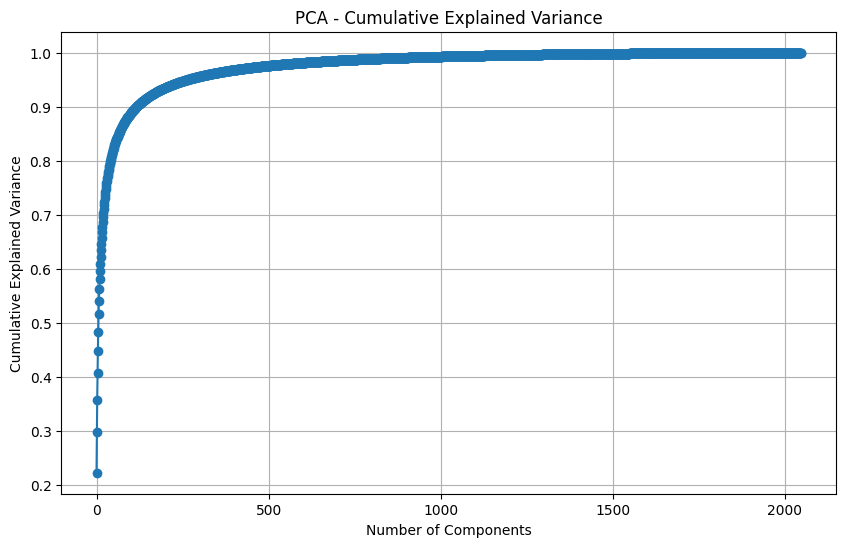

In [6]:
# Do full PCA
pca = PCA()
pca.fit(embeddings)

# Plot the cumulative explained variance to determine the optimal number of components
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.grid(True)
plt.show()

In [7]:
# Choose the number of components required to capture 95% of the original variance
n_components = np.argmax(cumulative_variance > 0.95)
pca = PCA(n_components=n_components)
embeddings_reduced = pca.fit_transform(embeddings)

# 'embeddings_reduced' now contains the reduced feature set
print("Reduced embeddings shape:", embeddings_reduced.shape)

Reduced embeddings shape: (68619, 263)


## Train models

In [8]:
# Target variable: `IWI`
X = embeddings_reduced
y = df['iwi'].values / 100.0 # Scale IWI to [0, 1]
countries = df['country']

X_train, X_test, y_train, y_test, countries_train, countries_test = train_test_split(X, y, countries, test_size=.2, random_state=RANDOM_STATE)

Helper function to perform training, hyperparameter tuning, and evaluation

In [21]:
def train_and_evaluate(model, params, X_train, y_train, X_test, y_test, n_iter=10):
    # RandomSearchCV for cross-validation and hyperparameter tuning
    random_search = RandomizedSearchCV(
        model, params, n_iter=n_iter, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=RANDOM_STATE
    )
    random_search.fit(X_train, y_train)
    
    # Best estimator and cross-validated score
    best_model = random_search.best_estimator_
    #print(f"Best parameters: {random_search.best_params_}")
    
    # Cross-validation score
    cv_score = -random_search.best_score_
    #print(f"Cross-validated MSE: {cv_score:.4f}")
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    #print(f"Test MSE: {test_mse:.4f}")
    #print(f"Test MAE: {test_mae:.4f}")
    #print(f"Test R^2: {test_r2:.4f}\n")
    
    return best_model, test_mae, test_r2

Define the models and hyperparameters to test

In [22]:
models = {
    'Lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
            'l1_ratio': [0.1, 0.5, 0.9, 0.99]
        }
    },
    'LightGBM': {
        'model': LGBMRegressor(random_state=RANDOM_STATE),
        'params': {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [10, 20, 30, -1]
        }
    },
    'MLP': {
        'model': MLPRegressor(max_iter=1000, random_state=RANDOM_STATE),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 50)],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate_init': [0.001, 0.01]
        }
    }
}

In [23]:
results = {}

percs = np.linspace(0.1, 1, 10)

for perc in tqdm(percs):
    results[perc] = {}
    n_samples = int(perc * len(X_train))
    results[perc]['n_samples'] = n_samples
    
    perc_X_train = X_train[:n_samples]
    perc_y_train = y_train[:n_samples]

    # Run training and evaluation for each model
    for model_name, model_data in models.items():
        # print(f"--- {model_name} ---")
        best_model, test_mae, test_r2 = train_and_evaluate(model_data['model'], model_data['params'], perc_X_train, perc_y_train, X_test, y_test, n_iter=10)

        results[perc][model_name] = {
            'best_model': best_model, 
            'test_mae': test_mae, 
            'test_r2': test_r2
        }

  0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
 10%|█         | 1/10 [00:07<01:09,  7.72s/it]/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
 

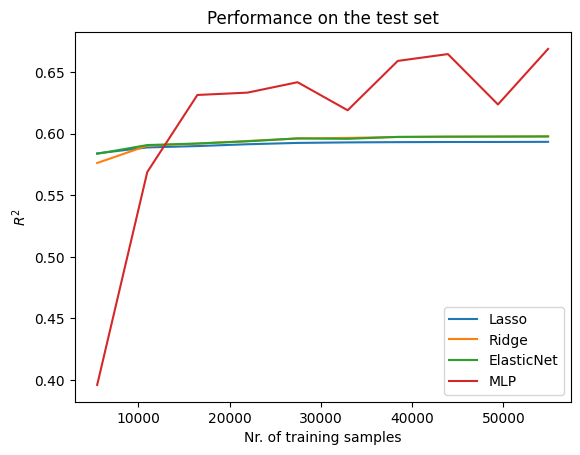

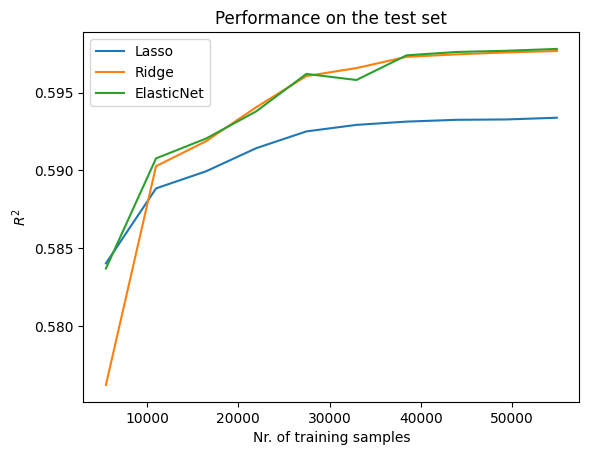

In [31]:
lasso = []
ridge = []
elastic_net = []
mlp = []
n_samples = []

t = 'test_r2'

for perc in percs:
    n_samples.append(results[perc]['n_samples'])
    lasso.append(results[perc]['Lasso'][t])
    ridge.append(results[perc]['Ridge'][t])
    elastic_net.append(results[perc]['ElasticNet'][t])
    mlp.append(results[perc]['MLP'][t])
    
plt.plot(n_samples, lasso, label='Lasso')
plt.plot(n_samples, ridge, label='Ridge')
plt.plot(n_samples, elastic_net, label='ElasticNet')
plt.plot(n_samples, mlp, label='MLP')
plt.legend()
plt.title('Performance on the test set')
plt.xlabel('Nr. of training samples')
plt.ylabel(r'$R^2$')
plt.show()

plt.plot(n_samples, lasso, label='Lasso')
plt.plot(n_samples, ridge, label='Ridge')
plt.plot(n_samples, elastic_net, label='ElasticNet')
plt.legend()
plt.title('Performance on the test set')
plt.xlabel('Nr. of training samples')
plt.ylabel(r'$R^2$')
plt.show()

In [11]:
from tqdm import tqdm

results = {}

for perc in 

# Run training and evaluation for each model
for model_name, model_data in tqdm(models.items()):
    print(f"--- {model_name} ---")
    best_model, test_mae, test_r2 = train_and_evaluate(model_data['model'], model_data['params'], X_train, y_train, X_test, y_test, n_iter=1)
    
    results[model_name] = {
        'best_model': best_model, 
        'test_mae': test_mae, 
        'test_r2': test_r2
    }

  0%|          | 0/5 [00:00<?, ?it/s]

--- Lasso ---


 20%|██        | 1/5 [00:00<00:03,  1.10it/s]

Best parameters: {'alpha': 0.001}
Cross-validated MSE: 0.0149
Test MSE: 0.0148
Test MAE: 0.0959
Test R^2: 0.5934

--- Ridge ---


 40%|████      | 2/5 [00:01<00:02,  1.32it/s]

Best parameters: {'alpha': 0.001}
Cross-validated MSE: 0.0147
Test MSE: 0.0146
Test MAE: 0.0952
Test R^2: 0.5977

--- ElasticNet ---


 60%|██████    | 3/5 [00:02<00:01,  1.35it/s]

Best parameters: {'l1_ratio': 0.1, 'alpha': 0.1}
Cross-validated MSE: 0.0170
Test MSE: 0.0169
Test MAE: 0.1038
Test R^2: 0.5360

--- LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67065
[LightGBM] [Info] Number of data points in the train set: 43916, number of used features: 263
[LightGBM] [Info] Start training from score 0.325942
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 67065
[LightGBM] [Info] Number of data points in the train set: 43916, number of used features: 263
[LightGBM] [Info] Start training from score 0.326023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

 80%|████████  | 4/5 [00:21<00:07,  7.85s/it]

Best parameters: {'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.2}
Cross-validated MSE: 0.0130
Test MSE: 0.0128
Test MAE: 0.0871
Test R^2: 0.6490

--- MLP ---


100%|██████████| 5/5 [00:37<00:00,  7.56s/it]

Best parameters: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,), 'alpha': 0.0001}
Cross-validated MSE: 0.0128
Test MSE: 0.0127
Test MAE: 0.0860
Test R^2: 0.6507



## Results

In [10]:
results

{'Lasso': {'best_model': Lasso(alpha=0.001),
  'test_mae': 0.09571508105087197,
  'test_r2': 0.5957755295159896},
 'Ridge': {'best_model': Ridge(alpha=0.001),
  'test_mae': 0.09490463591405188,
  'test_r2': 0.5995721426567091},
 'ElasticNet': {'best_model': ElasticNet(alpha=0.1, l1_ratio=0.1),
  'test_mae': 0.10359601725529229,
  'test_r2': 0.5401124270794929},
 'LightGBM': {'best_model': LGBMRegressor(learning_rate=0.2, n_estimators=200, random_state=42),
  'test_mae': 0.0868836411734599,
  'test_r2': 0.6540400712138992},
 'MLP': {'best_model': MLPRegressor(hidden_layer_sizes=(50,), max_iter=1000, random_state=42),
  'test_mae': 0.084225699989941,
  'test_r2': 0.6738335556858386}}

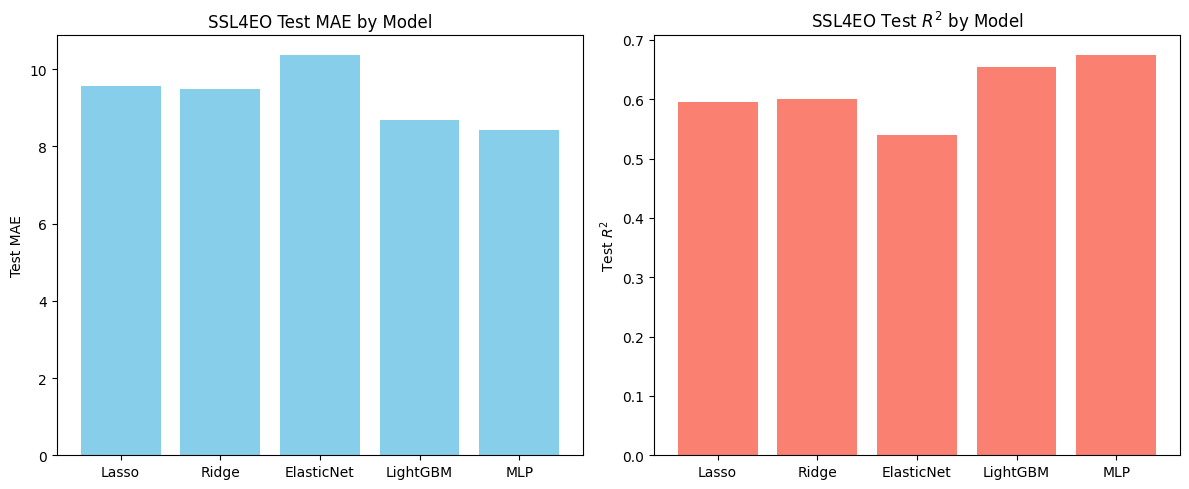

In [11]:
model_names = list(results.keys())
mae_scores = [100 * results[model]['test_mae'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [results[model]['test_r2'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("SSL4EO Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"SSL4EO Test $R^2$ by Model")

plt.tight_layout()
plt.show()

#### Plot results by country

In [12]:
from sklearn.model_selection import LeaveOneGroupOut

def evaluate_ooc(model, X, y, countries):
    
    logo = LeaveOneGroupOut()
    
    results = {}
    
    test_maes = []
    test_r2s = []

    for train_index, test_index in logo.split(X, y, countries):
        
        test_country = countries[test_index][0]
        X_test = X[test_index]
        y_test = y[test_index]
        
        y_pred = model.predict(X_test)
        country_mae = mean_absolute_error(y_test, y_pred)
        country_mse = mean_squared_error(y_test, y_pred)
        country_r2 = r2_score(y_test, y_pred)
        
        results[test_country] = {
            'test_mae': country_mae,
            'test_r2': country_r2,
            'residuals': y_test - y_pred
        }
        
        test_maes.append(country_mae)
        test_r2s.append(country_r2)
        
    mean_maes = np.mean(test_maes)
    mean_r2s = np.mean(test_r2s)
    
    results['mean_maes'] = mean_maes
    results['mean_r2s'] = mean_r2s
    
    print(f"Test MAE: {mean_maes:.4f}")
    print(f"Test R^2: {mean_r2s:.4f}\n")
    
    return results

In [21]:
ooc_results = {}

# Run training and evaluation for each model
for model_name, model_data in models.items():
    print(f"--- {model_name} ---")
    ooc_results[model_name] = evaluate_ooc(results[model_name]['best_model'], X_test, y_test, countries_test.values)

--- Lasso ---
Test MAE: 0.1009
Test R^2: 0.2348

--- Ridge ---
Test MAE: 0.1001
Test R^2: 0.2384

--- ElasticNet ---
Test MAE: 0.1088
Test R^2: 0.1368

--- LightGBM ---
Test MAE: 0.0915
Test R^2: 0.3487

--- MLP ---
Test MAE: 0.0888
Test R^2: 0.3766



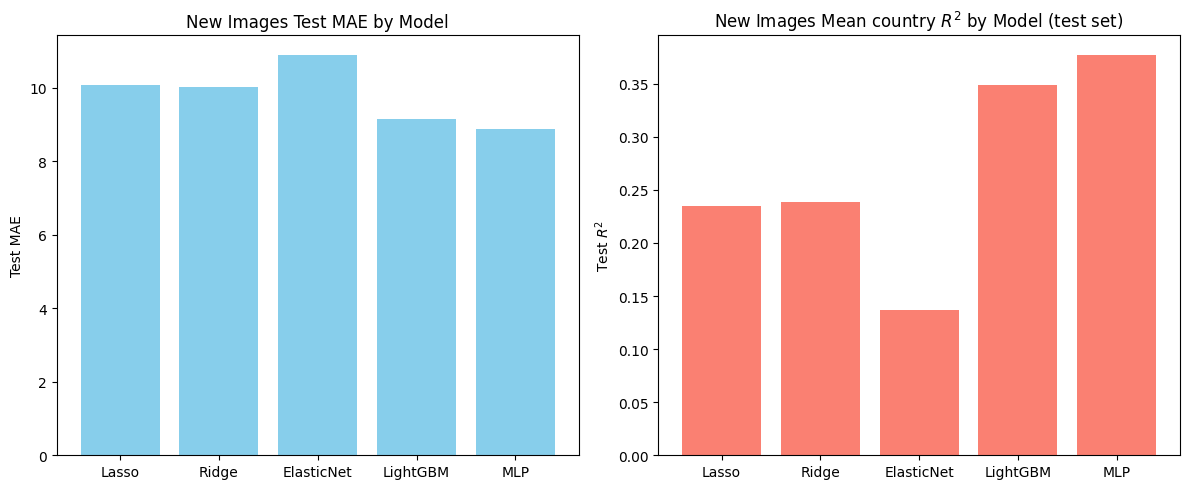

In [14]:
model_names = list(ooc_results.keys())
mae_scores = [100 * ooc_results[model]['mean_maes'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [ooc_results[model]['mean_r2s'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("New Images Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"New Images Mean country $R^2$ by Model (test set)")

plt.tight_layout()
plt.show()

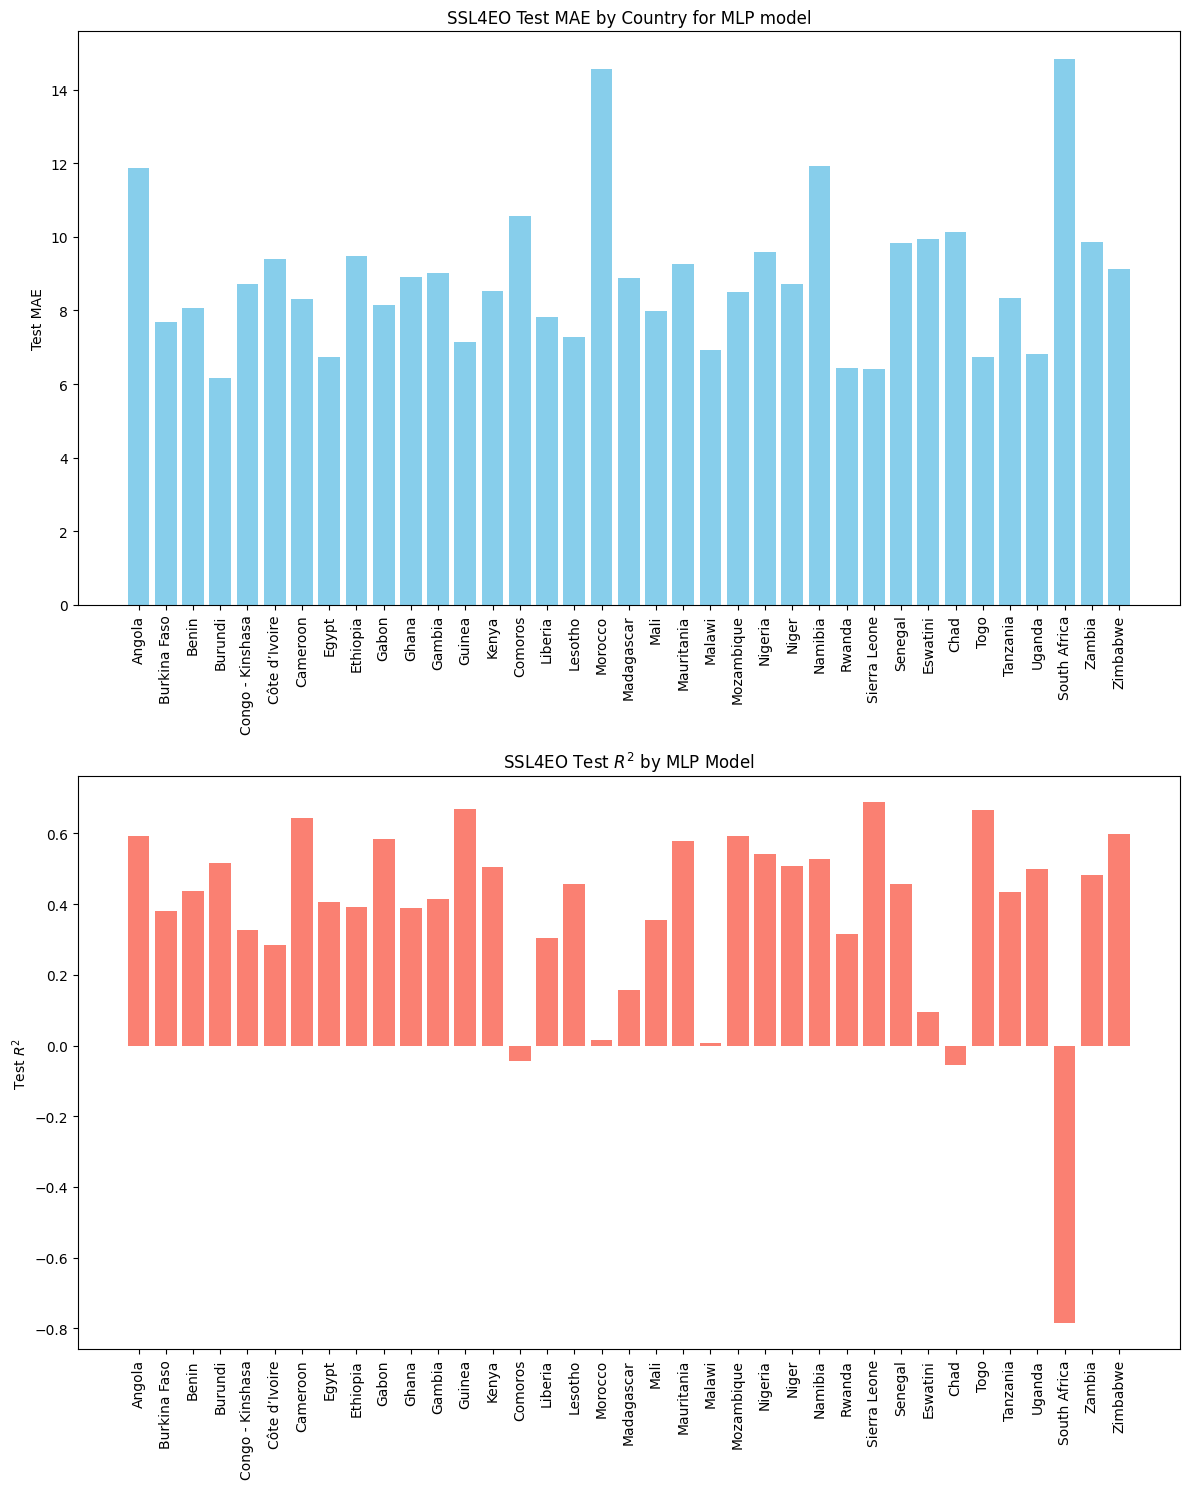

In [15]:
model_name = 'MLP'
mae_scores = []
r2_scores = []
country_names = countries.unique()

for country in country_names:
    mae_scores.append(ooc_results[model_name][country]['test_mae'] * 100)
    r2_scores.append(ooc_results[model_name][country]['test_r2'])
    
plt.figure(figsize=(12, 15))

# Plot MAE scores
plt.subplot(2, 1, 1)
plt.bar(country_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title(f"SSL4EO Test MAE by Country for {model_name} model")
plt.xticks(rotation=90)

# Plot R^2 scores
plt.subplot(2, 1, 2)
plt.bar(country_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"SSL4EO Test $R^2$ by " + model_name + " Model")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

In [43]:
ooc_results_df = pd.DataFrame(columns=['country', 'residuals'])

for country in country_names:
    residuals = ooc_results[model_name][country]['residuals']
    
    entry = pd.DataFrame.from_dict({
         'country': [country] * len(residuals),
         'residuals':  residuals
    })
    ooc_results_df = pd.concat([ooc_results_df, entry], ignore_index=True)

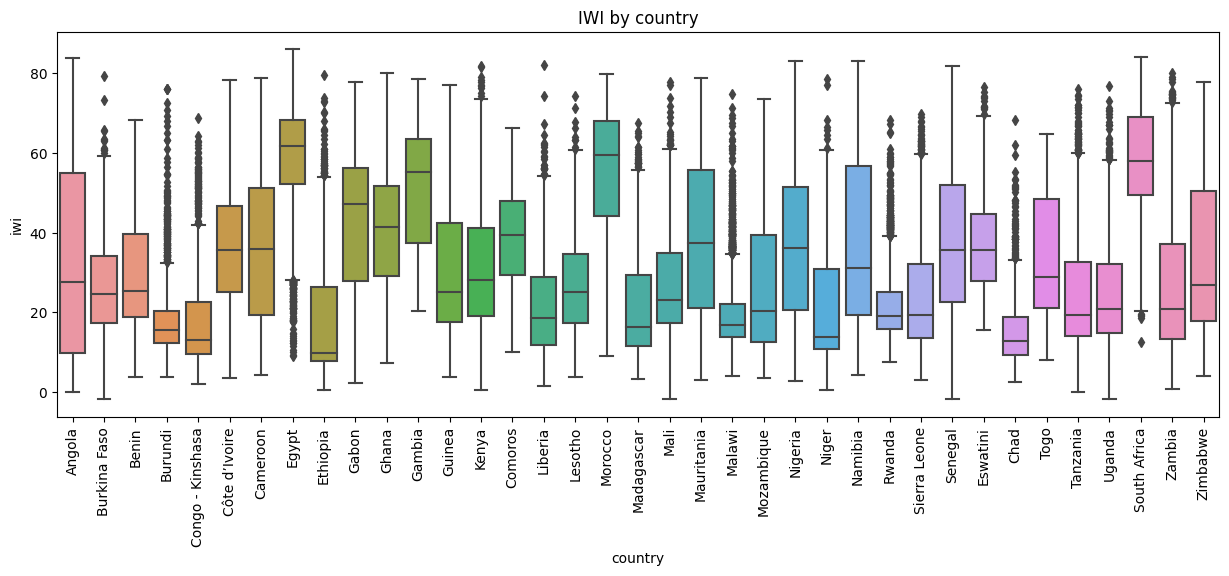

In [44]:
plt.figure(figsize=(15, 5))
sns.boxplot(df, y='iwi', x='country')
plt.xticks(rotation=90)
plt.title('IWI by country')
plt.show()

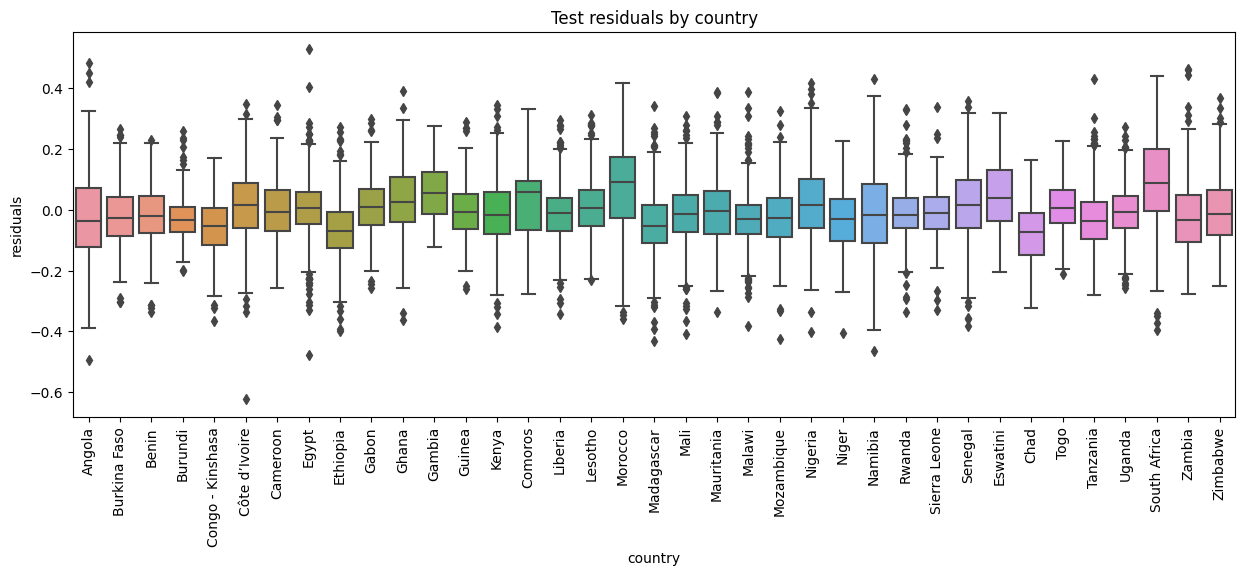

In [41]:
plt.figure(figsize=(15, 5))
sns.boxplot(ooc_results_df, y='residuals', x='country')
plt.xticks(rotation=90)
plt.title('Test residuals by country')
plt.show()

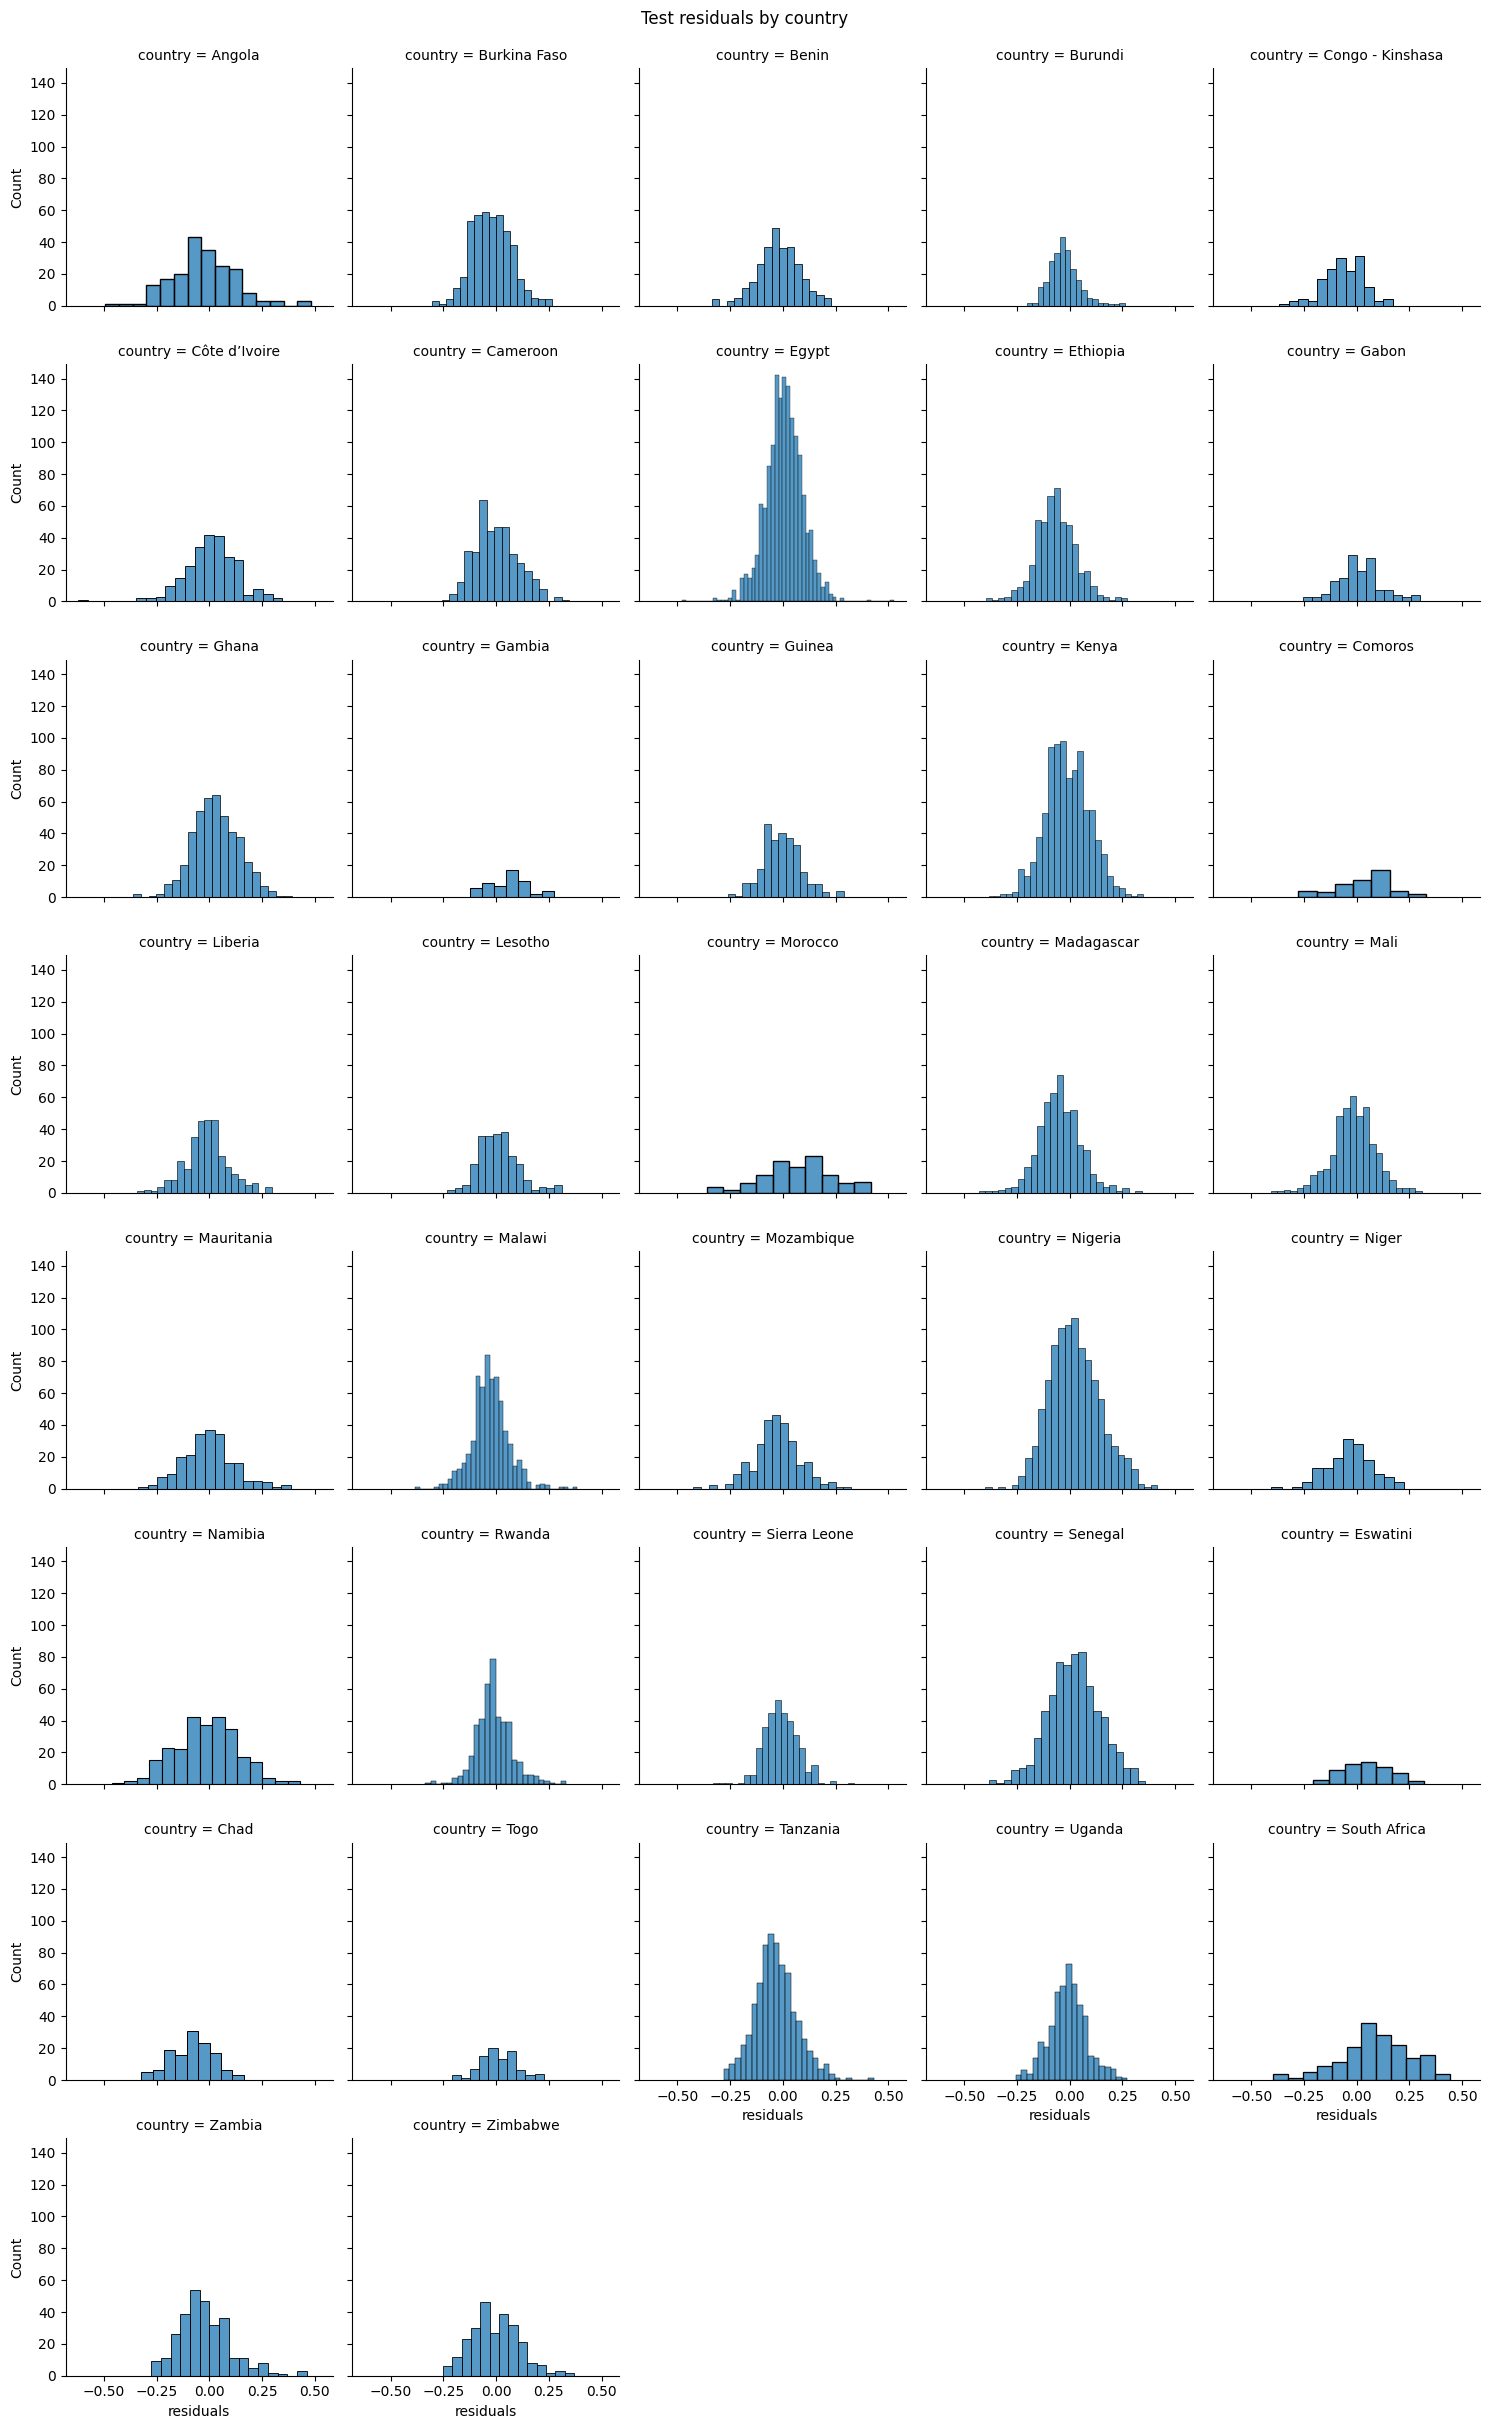

In [42]:
g = sns.FacetGrid(ooc_results_df, col="country", col_wrap=5)
g.map_dataframe(sns.histplot, x="residuals") #, binwidth=2, binrange=(0, 60))
plt.suptitle('Test residuals by country', y=1.01)
plt.show()

## Train Out-of-country models

In [27]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.base import clone

def train_and_evaluate_ooc(model, X, y, countries):
    
    logo = LeaveOneGroupOut()
    
    results = {}
    
    test_maes = []
    test_r2s = []

    for train_index, test_index in logo.split(X, y, countries):
        
        test_country = countries[test_index].iloc[0]
        country_model = clone(model)
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        country_model.fit(X_train, y_train)
        
        y_pred = country_model.predict(X_test)
        country_mae = mean_absolute_error(y_test, y_pred)
        country_mse = mean_squared_error(y_test, y_pred)
        country_r2 = r2_score(y_test, y_pred)
        
        results[test_country] = {
            'test_mae': country_mae,
            'test_r2': country_r2
        }
        
        test_maes.append(country_mae)
        test_r2s.append(country_r2)
        
    mean_maes = np.mean(test_maes)
    mean_r2s = np.mean(test_r2s)
    
    results['mean_maes'] = mean_maes
    results['mean_r2s'] = mean_r2s
    
    print(f"Test MAE: {mean_maes:.4f}")
    print(f"Test R^2: {mean_r2s:.4f}\n")
    
    return results

In [28]:
ooc_results = {}

# Run training and evaluation for each model
for model_name, model_data in models.items():
    print(f"--- {model_name} ---")
    ooc_results[model_name] = train_and_evaluate_ooc(results[model_name]['best_model'], X, y, countries)

--- Lasso ---
Test MAE: 0.1106
Test R^2: 0.0772

--- Ridge ---
Test MAE: 0.1111
Test R^2: -0.0272

--- ElasticNet ---
Test MAE: 0.1148
Test R^2: 0.0344

--- LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63495
[LightGBM] [Info] Number of data points in the train set: 67106, number of used features: 249
[LightGBM] [Info] Start training from score 0.327078
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 63495
[LightGBM] [Info] Number of data points in the train set: 66555, number of used features: 249
[LightGBM] [Info] Start training from score 0.327886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013041 seconds.
You can set `force_col_wise=true` to r

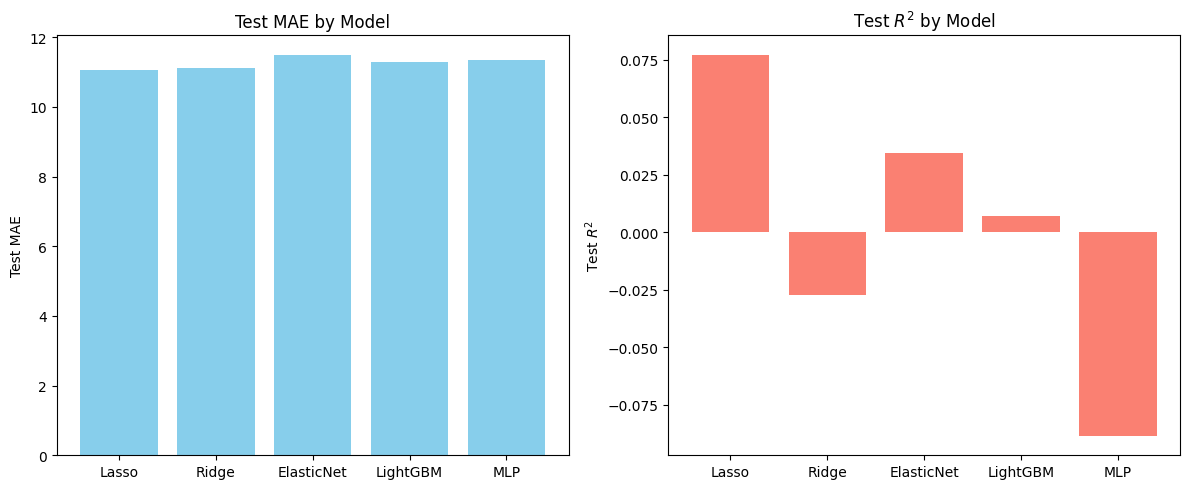

In [19]:
model_names = list(ooc_results.keys())
mae_scores = [100 * ooc_results[model]['mean_maes'] for model in model_names] # Rescale IWI back to [0, 100]
r2_scores = [ooc_results[model]['mean_r2s'] for model in model_names]

plt.figure(figsize=(12, 5))

# Plot MAE scores
plt.subplot(1, 2, 1)
plt.bar(model_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title("Test MAE by Model")

# Plot R^2 scores
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"Test $R^2$ by Model")

plt.tight_layout()
plt.show()

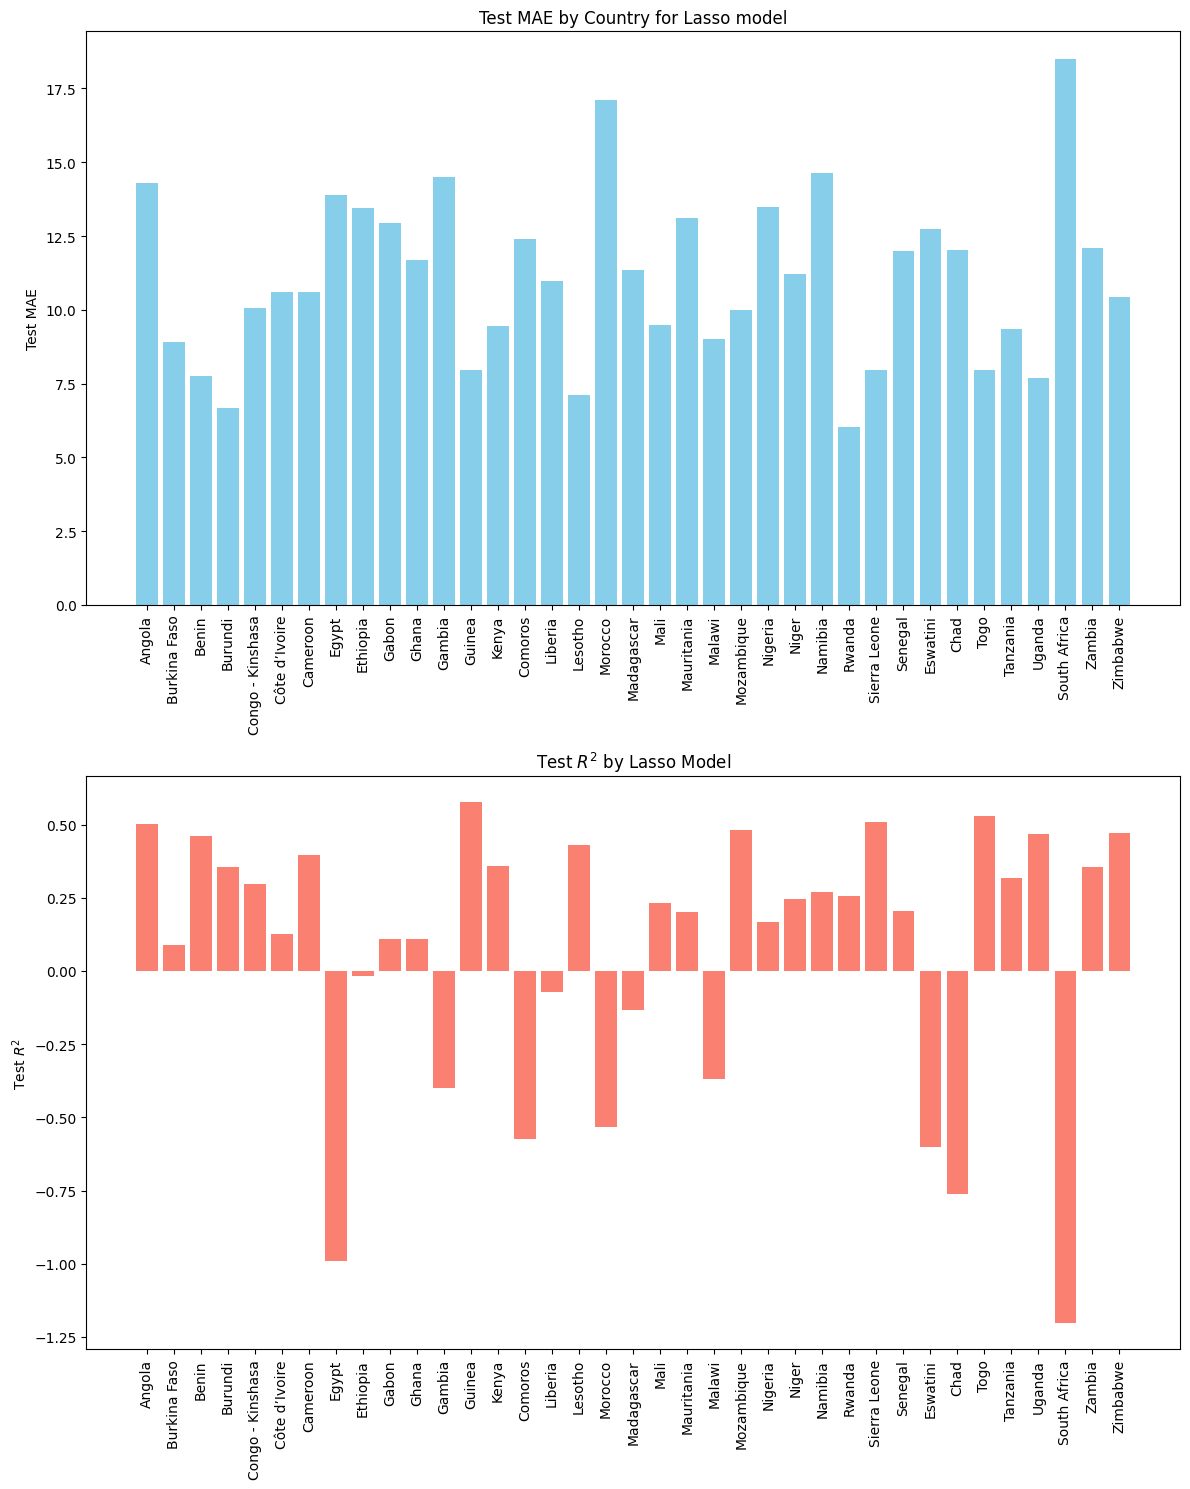

In [21]:
model_name = 'Lasso'
mae_scores = []
r2_scores = []
country_names = countries.unique()

for country in country_names:
    mae_scores.append(ooc_results[model_name][country]['test_mae'] * 100)
    r2_scores.append(ooc_results[model_name][country]['test_r2'])
    
plt.figure(figsize=(12, 15))

# Plot MAE scores
plt.subplot(2, 1, 1)
plt.bar(country_names, mae_scores, color='skyblue')
plt.ylabel("Test MAE")
plt.title(f"Test MAE by Country for {model_name} model")
plt.xticks(rotation=90)

# Plot R^2 scores
plt.subplot(2, 1, 2)
plt.bar(country_names, r2_scores, color='salmon')
plt.ylabel(r"Test $R^2$")
plt.title(r"Test $R^2$ by " + model_name + " Model")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()